# Building Concatenated Model

In [1]:
cd CrisisMMD_Dataset

[Errno 2] No such file or directory: 'CrisisMMD_Dataset'
/notebooks/CrisisMMD_Dataset


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from Precision_Module import Precision1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import aidrtokenize
from sklearn.metrics import classification_report

In [5]:
path = Path('/notebooks/CrisisMMD_Dataset')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# import tarfile
# zf = tarfile.open("CrisisMMD_v2.tar.gz")
# zf.extractall()

In [8]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [9]:
data_human_text_image_file = 'new_task_humanitarian_text_img_agreed_lab_human_data.tsv'
test_data_human_text_image_file = 'new_task_humanitarian_text_img_agreed_lab_test_data.tsv' 

In [11]:
if data_human_text_image_file and test_data_human_text_image_file in path.ls():
    data_human_text_image_file = pd.read_csv('new_task_humanitarian_text_img_agreed_lab_human_data.tsv',delimiter='\t',encoding='utf-8')
    test_human_text_image_file = pd.read_csv('task_humanitarian_text_img_agreed_lab_test_data.tsv',delimiter='\t',encoding='utf-8')
else:
    train_human_text_image=pd.read_csv('task_humanitarian_text_img_agreed_lab_train.tsv',delimiter='\t',encoding='utf-8')
    train_human_text_image = train_human_text_image.drop(0,axis=0)
    test_human_text_image=pd.read_csv('task_humanitarian_text_img_agreed_lab_test.tsv',delimiter='\t',encoding='utf-8')
    dev_human_text_image=pd.read_csv('task_humanitarian_text_img_agreed_lab_dev.tsv',delimiter='\t',encoding='utf-8')
    
    train_human_text_image['tweet_text']=train_human_text_image['tweet_text'].apply(lambda x:aidrtokenize.tokenize(x))
    dev_human_text_image['tweet_text']=dev_human_text_image['tweet_text'].apply(lambda x:aidrtokenize.tokenize(x))
    test_human_text_image['tweet_text']=test_human_text_image['tweet_text'].apply(lambda x:aidrtokenize.tokenize(x))
    
    train_human_text_image['tweet_text'] = train_human_text_image['tweet_text'].apply(lambda x:clean_ascii(x))
    dev_human_text_image['tweet_text'] = dev_human_text_image['tweet_text'].apply(lambda x:clean_ascii(x))
    test_human_text_image['tweet_text'] = test_human_text_image['tweet_text'].apply(lambda x:clean_ascii(x))
    
    train_human_text_image['is_valid'] = False
    dev_human_text_image['is_valid'] = True
    test_human_text_image['is_valid'] = False 

    train_human_text_image['is_test'] = False
    dev_human_text_image['is_test'] = False
    test_human_text_image['is_test'] = True
    
    data_human_text_image = pd.concat([train_human_text_image,dev_human_text_image],axis=0).reset_index()
    data_human_text_image = data_human_text_image.drop(['index'],axis=1)
    
    test_data_human_text_image = pd.concat([train_human_text_image,test_human_text_image],axis=0).reset_index()
    test_data_human_text_image = test_data_human_text_image.drop(['index'],axis=1)
    
    data_human_text_image.to_csv('new_task_humanitarian_text_img_agreed_lab_human_data.tsv',encoding='utf-8')
    test_data_human_text_image.to_csv('new_task_humanitarian_text_img_agreed_lab_test_data.tsv',encoding='utf-8')

In [12]:
print(f"shape of data: {data_human_text_image.shape}\n")
print(data_human_text_image['is_valid'].value_counts())
print("="*50)
print(f"shape of test data: {test_data_human_text_image.shape}\n")
print(test_data_human_text_image['is_test'].value_counts())

shape of data: (7123, 11)

False    6125
True      998
Name: is_valid, dtype: int64
shape of test data: (7080, 11)

False    6125
True      955
Name: is_test, dtype: int64


In [13]:
data_lm = (TextList
           .from_df(data_human_text_image,path, cols='tweet_text')
           #Where are the text? Column 'text' of texts.csv
           .split_from_df(col='is_valid')
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch())
           #Finally we convert to a DataBunch

In [14]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [15]:
data_clas = (TextList.from_df(data_human_text_image,path,cols='tweet_text',vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label_text')
                   .databunch())

In [16]:
test_data_clas = (TextList.from_df(test_data_human_text_image,path,cols='tweet_text',vocab=data_lm.vocab)
                   .split_from_df(col='is_test')
                   .label_from_df(cols='label_text')
                   .databunch())

In [17]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy,
                                                                                Precision(average='macro'),Precision(average='weighted'),
                                                                                Recall(average='macro'),Recall(average='weighted'),
                                                                                FBeta(average='macro',beta=1),FBeta(average='weighted',beta=1)])

In [18]:
learn_clas.load_encoder('fine_tuned_enc_human')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6125 items)
x: TextList
xxbos california wildfires destroy more than structures xxunk,xxbos california wildfires destroy more than structures xxunk,xxbos photos of california destructive wildfires via,xxbos why california wildfires are worse in the fall,xxbos why california wildfires are worse in the fall
y: CategoryList
infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,other_relevant_information,other_relevant_information
Path: /notebooks/CrisisMMD_Dataset;

Valid: LabelList (998 items)
x: TextList
xxbos family xxunk finds dog they lost when escaping california wildfires,xxbos hurricane irma on twitter,xxbos feel xxunk by xxunk in so many levels how xxunk can picture xxunk me so bad on the floor while preparing for,xxbos postirma can xxunk so true,xxbos hurricane maria remains severe threat sept utc
y: CategoryList
not_humanitarian,other_relevant_information,not_humanitarian,not_h

In [19]:
tfms = get_transforms()

data_img = (ImageList.from_df(data_human_text_image,path,cols='image')
        #Where to find the data? -> in planet 'train' folder
        .split_from_df(col='is_valid')
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(cols='label_image')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=224)
        #Data augmentation? -> use tfms with a size of 128
        .databunch()
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

In [20]:
test_data_img = (ImageList.from_df(test_data_human_text_image,path,cols='image')
        #Where to find the data? -> in planet 'train' folder
        .split_from_df(col='is_test')
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(cols='label_image')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=224)
        #Data augmentation? -> use tfms with a size of 128
        .databunch()
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

In [21]:
arch = models.resnet50
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [22]:
# learn_img.model

In [23]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [24]:
# learn_clas.model

In [25]:
learn_clas.model[-1].layers = learn_clas.model[-1].layers[:-3]
# learn_clas.model

In [26]:
train_img_file = path/'train_img_human.pkl'
valid_img_file = path/'valid_img_human.pkl'

In [27]:
if train_img_file and valid_img_file in path.ls():
    with open('train_img_human.pkl','rb') as f:
        train_img=pickle.load(f)
    with open('valid_img_human.pkl','rb') as f:
        valid_img=pickle.load(f)
else:
    train_img=[data_img.train_ds[i][0].data for i in range(len(data_img.train_ds))]
    valid_img = [data_img.valid_ds[i][0].data for i in range(len(data_img.valid_ds))]
    with open('train_img_human.pkl','wb') as f:
        pickle.dump(train_img,f)
    with open('valid_img_human.pkl','wb') as f:
        pickle.dump(valid_img,f)

In [28]:
test_img_file = path/'test_img_human.pkl'

if test_img_file in path.ls():
    with open('test_img_human.pkl','rb') as f:
        test_img=pickle.load(f)
else:
    test_img=[test_data_img.valid_ds[i][0].data for i in range(len(test_data_img.valid_ds))]
    with open('test_img_human.pkl','wb') as f:
        pickle.dump(test_img,f)

In [29]:
# train_img=[data_img.train_ds[i][0].data for i in range(len(data_img.train_ds))]

In [30]:
# valid_img = [data_img.valid_ds[i][0].data for i in range(len(data_img.valid_ds))]

In [31]:
class ConcatDataset(Dataset):
    def __init__(self, x1, x2, y): 
        self.x1,self.x2,self.y,self.c = x1,x2,y,len(y.classes)
        
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, i): 
        return (self.x1[i], self.x2[i]), self.y[i]

In [32]:
train_ds = ConcatDataset(train_img, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(valid_img, data_clas.valid_ds.x, data_clas.valid_ds.y)

In [33]:
test_train_ds = ConcatDataset(train_img, test_data_clas.train_ds.x, test_data_clas.train_ds.y)
test_ds = ConcatDataset(test_img, test_data_clas.valid_ds.x, test_data_clas.valid_ds.y)

In [34]:
def my_collate(batch):    
    x,y = list(zip(*batch))
    x1,x2 = list(zip(*x))
    bs=len(x1)
    x1 =[x1[i].unsqueeze(dim=0) for i in range(bs)]
    x1 = torch.cat(x1,dim=0)
    x1 = x1.unsqueeze(dim=0)
    x2, y = pad_collate(list(zip(x2, y)), pad_idx=1, pad_first=True)
    return (x1,x2),y

In [35]:
bs = 32
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))

In [36]:
bs = 32
test_train_sampler = SortishSampler(test_data_clas.train_ds.x, key=lambda t: len(test_data_clas.train_ds[t][0].data), bs=bs//2)
test_sampler = SortSampler(test_data_clas.valid_ds.x, key=lambda t: len(test_data_clas.valid_ds[t][0].data))

In [37]:
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)

In [38]:
test_train_dl = DataLoader(test_train_ds, bs, sampler=test_train_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [39]:
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [40]:
(x1,x2),y = next(iter(data.valid_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([1, 32, 3, 224, 224])
Shape text batch: torch.Size([32, 24])
Shape dependent var: torch.Size([32])


In [41]:
class ConcatModel(nn.Module):
    def __init__(self, mod_img, mod_clas, layers, drops): 
        super().__init__()
        self.mod_img = mod_img
        self.mod_clas = mod_clas
        lst_layers = []
        activs = [nn.ReLU(inplace=True),] * (len(layers)-2) + [None]
        for n_in,n_out,p,actn in zip(layers[:-1], layers[1:], drops, activs):
            lst_layers += bn_drop_lin(n_in, n_out, p=p, actn=actn)
        self.layers = nn.Sequential(*lst_layers)

    def forward(self,*x):
        x[0][0].view(-1,3,224,224)
        x_img = self.mod_img(x[0][0])
        x_clas = self.mod_clas(x[1])[0]
        x = torch.cat([x_img, x_clas], dim=1)
        x = self.layers(x)
        return x 

In [42]:
lin_layers = [512+50, 5]
ps = [0.8]
model = ConcatModel(learn_img.model, learn_clas.model, lin_layers, ps)

In [44]:
loss_func = nn.CrossEntropyLoss()
layer_groups = [nn.Sequential(*flatten_model(learn_clas.layer_groups[0])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[1])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[2])),
                nn.Sequential(*flatten_model(learn_clas.layer_groups[3])),
                nn.Sequential(*(flatten_model(learn_clas.layer_groups[4]) + 
                                flatten_model(model.mod_img) +
                                flatten_model(model.layers)))]
# layer_groups=layer_groups


model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(SaveModelCallback,every='improvement', monitor='valid_loss', name='best'),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [45]:
learn.freeze()

In [46]:
# learn.lr_find()

In [47]:
# learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,1.265441,0.915811,0.736473,0.544965,0.761393,0.607117,0.736473,0.564960,0.740681,00:59
1,0.870201,0.738715,0.786573,0.599453,0.780894,0.601713,0.786573,0.599572,0.782541,00:55
2,0.547151,0.807294,0.789579,0.599201,0.786318,0.625693,0.789579,0.610477,0.786926,00:55


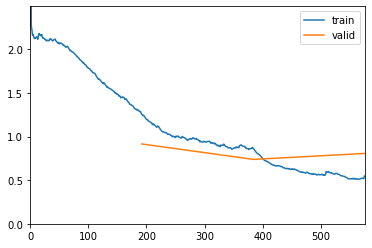

Better model found at epoch 0 with valid_loss value: 0.9158108830451965.
Better model found at epoch 1 with valid_loss value: 0.7387149930000305.


In [48]:
learn.fit_one_cycle(3,8e-5, moms=(0.8, 0.7),wd=1e-1)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,1.223734,2.088800,0.701403,0.553111,0.697213,0.434458,0.701403,0.442194,0.672837,00:56
1,1.000921,1.062436,0.737475,0.581282,0.728436,0.498248,0.737475,0.525545,0.723475,00:56


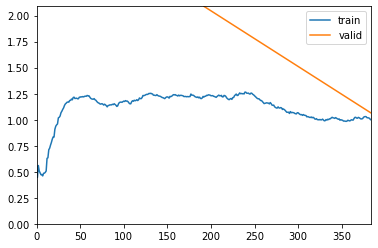

Better model found at epoch 0 with valid_loss value: 2.0888001918792725.
Better model found at epoch 1 with valid_loss value: 1.0624359846115112.


In [49]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.954839,0.772644,0.709419,0.557637,0.699115,0.459942,0.709419,0.485745,0.690098,00:57
1,0.875024,0.626302,0.779559,0.610522,0.773453,0.565083,0.779559,0.580958,0.770848,00:57
2,0.707445,0.604084,0.779559,0.604783,0.772575,0.572975,0.779559,0.586324,0.772415,00:57


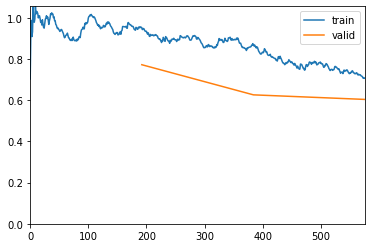

Better model found at epoch 0 with valid_loss value: 0.7726439237594604.
Better model found at epoch 1 with valid_loss value: 0.6263018250465393.
Better model found at epoch 2 with valid_loss value: 0.6040844917297363.


In [50]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

In [51]:
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot_lr()

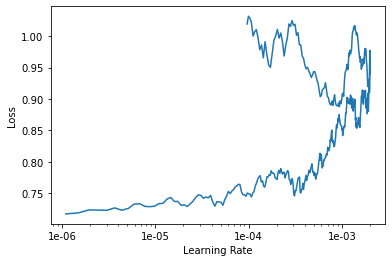

In [52]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.682242,0.574134,0.785571,0.606861,0.777340,0.575586,0.785571,0.588747,0.778388,00:59
1,0.641058,0.620711,0.786573,0.604252,0.778368,0.592238,0.786573,0.597621,0.781515,00:59


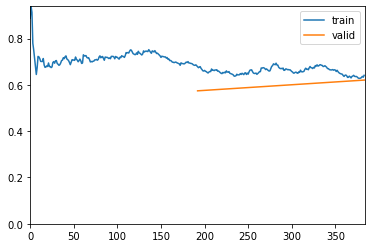

Better model found at epoch 0 with valid_loss value: 0.5741336345672607.


In [53]:
learn.fit_one_cycle(2, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.633883,0.663774,0.770541,0.603973,0.765848,0.558695,0.770541,0.576551,0.761642,00:59
1,0.668065,1.945915,0.766533,0.614857,0.760174,0.548284,0.766533,0.574548,0.756914,00:59
2,0.576718,0.638479,0.788577,0.610865,0.781893,0.590034,0.788577,0.598672,0.782605,00:59
3,0.536377,0.649134,0.791583,0.612584,0.786147,0.591891,0.791583,0.599946,0.785519,00:59
4,0.528201,0.643614,0.790581,0.609807,0.783636,0.593824,0.790581,0.600320,0.784932,00:59


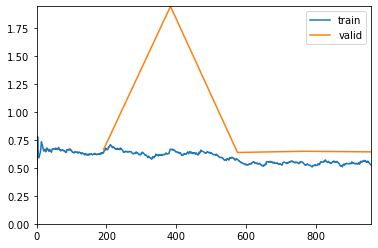

Better model found at epoch 0 with valid_loss value: 0.6637739539146423.
Epoch 1: reducing lr to 9.504846320134737e-05
Better model found at epoch 2 with valid_loss value: 0.6384791135787964.
Epoch 3: reducing lr to 1.88258346050237e-05


In [54]:
learn.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7), wd=1e-1)

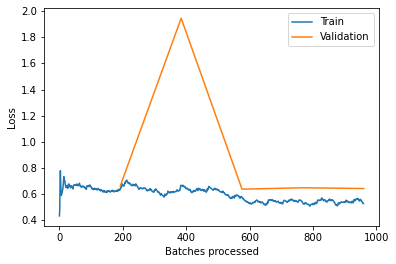

In [55]:
learn.recorder.plot_losses()

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

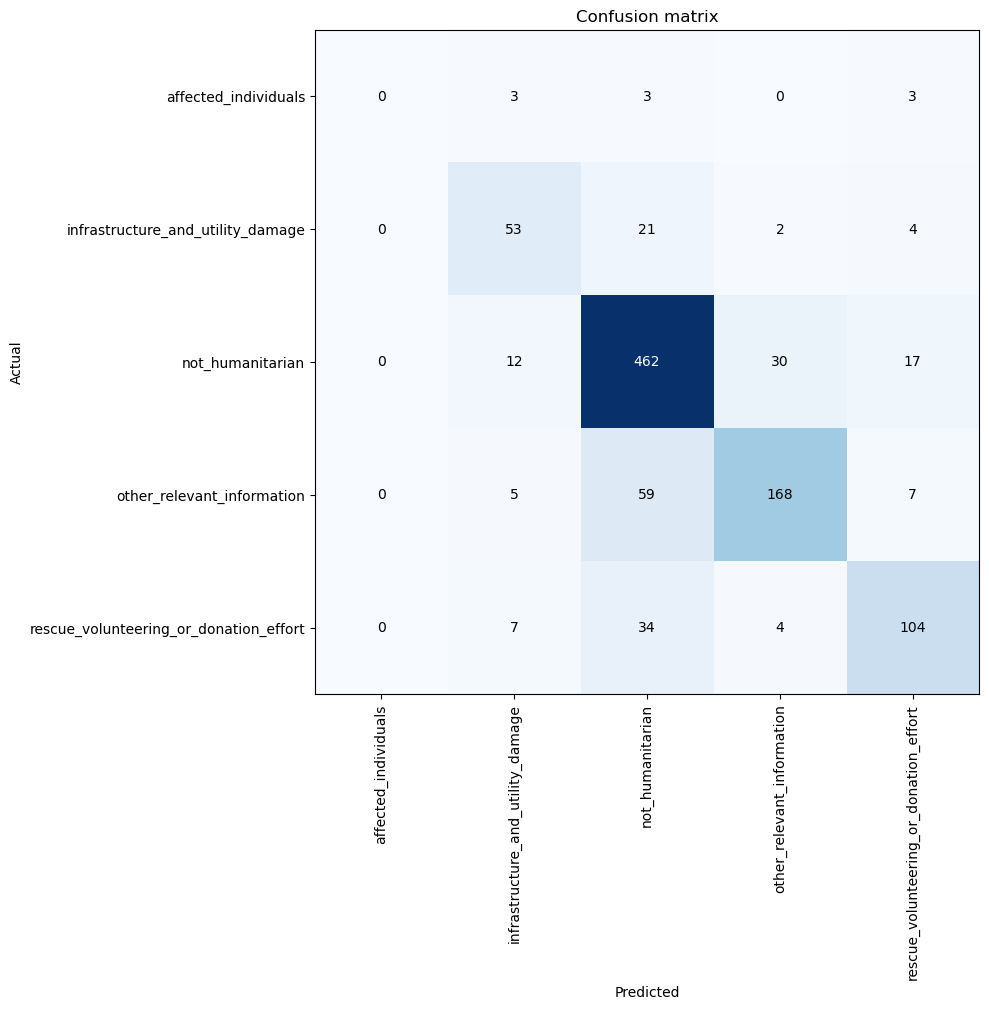

In [57]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=100)

In [59]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.6384791,
 tensor(0.7886),
 tensor(0.6109),
 tensor(0.7819),
 tensor(0.5900),
 tensor(0.7886),
 tensor(0.5987),
 tensor(0.7826)]

In [60]:
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.00      0.00      0.00         9
     infrastructure_and_utility_damage       0.66      0.66      0.66        80
                      not_humanitarian       0.80      0.89      0.84       521
            other_relevant_information       0.82      0.70      0.76       239
rescue_volunteering_or_donation_effort       0.77      0.70      0.73       149

                              accuracy                           0.79       998
                             macro avg       0.61      0.59      0.60       998
                          weighted avg       0.78      0.79      0.78       998



/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.6384791,
 tensor(0.7886),
 tensor(0.6109),
 tensor(0.7819),
 tensor(0.5900),
 tensor(0.7886),
 tensor(0.5987),
 tensor(0.7826)]

In [62]:
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.00      0.00      0.00         9
     infrastructure_and_utility_damage       0.76      0.70      0.73        81
                      not_humanitarian       0.80      0.86      0.83       504
            other_relevant_information       0.80      0.74      0.77       235
rescue_volunteering_or_donation_effort       0.70      0.67      0.69       126

                              accuracy                           0.79       955
                             macro avg       0.61      0.60      0.60       955
                          weighted avg       0.78      0.79      0.78       955



/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
